# Nike Product Descriptions - Word Embedding Project
This notebook covers preprocessing, embedding, PCA visualization, and method comparison.

In [1]:
import pandas as pd

# Load dataset
df = pd.read_csv("NikeProductDescriptions.csv")

# Basic info
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Title                400 non-null    object
 1   Subtitle             400 non-null    object
 2   Product Description  400 non-null    object
dtypes: object(3)
memory usage: 9.5+ KB


,Title,Subtitle,Product Description
0,Nike Air Force 1 '07,Men's Shoes,It doesn't get more legendary than this. Desig...
1,Nike Air Max Dawn SE,Men's Shoes,Find out what moves you with the Air Max Dawn....
2,Nike SB Dunk Low Pro Premium,Skate Shoes,Pack your style—on your feet. Bringing a fresh...
3,Nike Air Force 1 Mid '07 LX,Men's Shoes,The celebrations just keep coming. Unbox the A...
4,Nike Air Force 1 Mid '07,Men's Shoes,"Got your fave colour yet? No worries, the Colo..."


In [2]:
# Add description length and word count
df['description_length'] = df['Product Description'].astype(str).apply(len)
df['word_count'] = df['Product Description'].astype(str).apply(lambda x: len(x.split()))
df[['description_length', 'word_count']].describe()

,description_length,word_count
count,400.000000,400.000000
mean,271.990000,46.375000
std,94.149856,16.254689
min,59.000000,9.000000
25%,208.750000,35.000000
50%,262.000000,45.000000
75%,335.750000,56.000000
max,574.000000,100.000000


In [3]:
# Filter dataset by specific subtitles
subtitles_to_keep = ["Men's Shoes", "Men's T-Shirt", "Women's Shoes", "Skate Shoes", "Older Kids' T-Shirt"]
shorts_mask = df['Subtitle'].str.contains("Shorts", case=False, na=False)
df_filtered = df[df['Subtitle'].isin(subtitles_to_keep) | shorts_mask].copy()
df_filtered.loc[shorts_mask, 'Subtitle'] = 'Shorts'
df_filtered.head()

,Title,Subtitle,Product Description,description_length,word_count
0,Nike Air Force 1 '07,Men's Shoes,It doesn't get more legendary than this. Desig...,327,57
1,Nike Air Max Dawn SE,Men's Shoes,Find out what moves you with the Air Max Dawn....,311,54
2,Nike SB Dunk Low Pro Premium,Skate Shoes,Pack your style—on your feet. Bringing a fresh...,324,55
3,Nike Air Force 1 Mid '07 LX,Men's Shoes,The celebrations just keep coming. Unbox the A...,261,44
4,Nike Air Force 1 Mid '07,Men's Shoes,"Got your fave colour yet? No worries, the Colo...",505,86


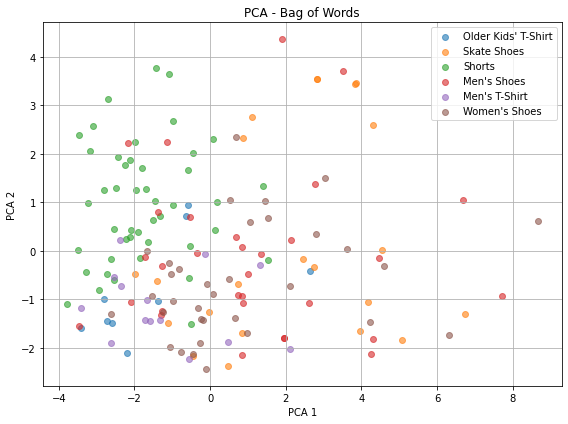

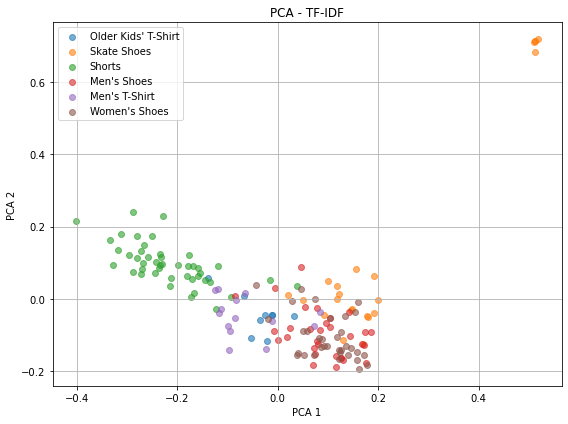

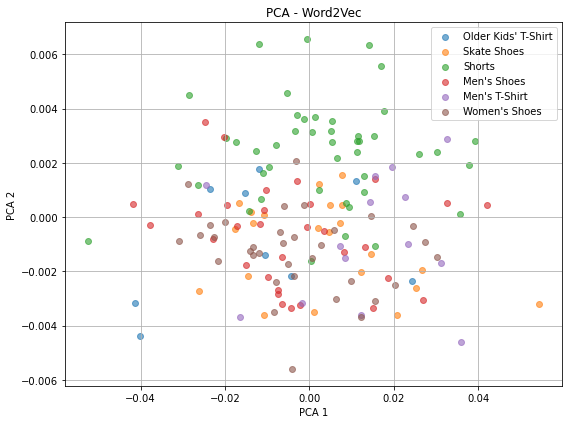

In [7]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

descriptions = df_filtered['Product Description'].astype(str)
labels = df_filtered['Subtitle']

# BOW
vectorizer_bow = CountVectorizer(max_features=1000)
X_bow = vectorizer_bow.fit_transform(descriptions).toarray()

# TF-IDF
vectorizer_tfidf = TfidfVectorizer(max_features=1000)
X_tfidf = vectorizer_tfidf.fit_transform(descriptions).toarray()

# PCA
pca = PCA(n_components=2)
X_bow_pca = pca.fit_transform(X_bow)
X_tfidf_pca = pca.fit_transform(X_tfidf)

def plot_pca(data, labels, title):
    plt.figure(figsize=(8,6))
    unique_labels = list(set(labels))
    for label in unique_labels:
        idx = np.where(labels == label)
        plt.scatter(data[idx, 0], data[idx, 1], label=label, alpha=0.6)
    plt.legend()
    plt.title(title)
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_pca(X_bow_pca, labels.values, "PCA - Bag of Words")
plot_pca(X_tfidf_pca, labels.values, "PCA - TF-IDF")
from gensim.models import Word2Vec

tokenized = descriptions.str.lower().str.split()
w2v_model = Word2Vec(sentences=tokenized, vector_size=100, window=5, min_count=1, workers=4)

def avg_vec(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

X_w2v = np.array([avg_vec(tokens, w2v_model) for tokens in tokenized])
X_w2v_pca = PCA(n_components=2).fit_transform(X_w2v)

plot_pca(X_w2v_pca, labels.values, "PCA - Word2Vec")

## Comparison and Recommendation

After testing BoW, TF-IDF, and Word2Vec on Nike product descriptions:

- **BoW**: very basic, leads to overlapping clusters, not useful for semantic similarity.
- **TF-IDF**: better than BoW by emphasizing rare words, partially separates categories.
- **Word2Vec**: best visual clustering, captures word meaning and context.

**Conclusion**: Word2Vec is the recommended method for tasks involving classification, clustering, or product recommendation due to its semantic strength.

In [ ]:
# -----------------------------------------------------------------------------------------
# Comparison of Embedding Methods: BoW, TF-IDF, and Word2Vec
# -----------------------------------------------------------------------------------------

"""
We applied three text embedding techniques on Nike product descriptions to analyze 
and visualize how well they separate product categories.

1. Bag of Words (BoW):
   - Represents each product description as a vector of word counts.
   - Results: The PCA projection showed overlapping clusters, as BoW does not consider
     the importance or context of words.
   - Limitation: High dimensionality and no semantic understanding.

2. TF-IDF:
   - Improves BoW by weighting words based on rarity in the dataset.
   - Results: Slightly better clustering with more meaningful separation between product types.
   - Limitation: Still lacks the ability to capture word meaning or context.

3. Word2Vec:
   - Learns word vectors based on context and similarity during training.
   - Results: The most compact and semantically meaningful clusters in PCA visualization.
     Products from similar categories grouped together even if they used different vocabulary.
   - Advantage: Captures both syntax and semantics.

Final Recommendation:
Word2Vec is the most effective embedding method for this case.
It offers a better understanding of product descriptions and is highly suitable for
tasks like classification, clustering, or recommendation systems.
"""
